In [1]:
import torch
import pyro

pyro.set_rng_seed(101)

In [2]:
loc = 0.
scale = 1. 

normal = torch.distributions.Normal(loc, scale)
x = normal.rsample()
print("sample", x)
print("log prob", normal.log_prob(x))

sample tensor(-1.3905)
log prob tensor(-1.8857)


In [6]:
def weather_pytorch():
    '''A pytorch stochastic primitive on how to sample data'''
    
    cloudy = torch.distributions.Bernoulli(0.3).sample()
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = torch.distributions.Normal(mean_temp, scale_temp).rsample()
    
    return cloudy, temp.item()

In [8]:
def weather():
    '''
    Redefining the pytorch equivalent in form of named pyro primitive
    pyro.sample() is a probabilistic primitive that takes a name for inference and the sampling distribution
    pyro.distributions is a thin wrapper on torch.distributions
    '''
    
    cloudy = pyro.sample('cloudy', pyro.distributions.Bernoulli(0.3))
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = pyro.sample('temp', pyro.distributions.Normal(mean_temp, scale_temp))
    
    return cloudy, temp.item()

for _ in range(3):
    print(weather())
    

('cloudy', 52.48044204711914)
('sunny', 68.44023895263672)
('sunny', 80.18768310546875)


In [9]:
def ice_cream_sales():
    '''
    We can condition further to create higher order stochasticity
    '''
    
    cloudy, temp = weather()
    expected_sales = 200 if cloudy == 'sunny' and temp > 80.0 else 50
    ice_cream = pyro.sample('ice_cream', pyro.distributions.Normal(expected_sales, 10.0))
    return ice_cream

In [26]:
def geometric(p, t=None):
    '''
    A geometric distribution typically measures the number of trials for the first success, each trial of which
    follows a Bernoulli distribution. We can use natural python syntax, such as recursion, to simulate this without
    a geometric call (aka time to terminate), because Pyro is embedded in python, and follows typical python control
    flow. The t parameter is required for separate naming, as the t^th trial
    '''
    
    if t is None:
        t = 0
    
    x = pyro.sample("x_{}".format(t), pyro.distributions.Bernoulli(p))
    if x.item() == 1:
        return 0
    
    else:
        return 1 + geometric(p, t + 1)
    
n_trials = 1000
total = 0
for _ in range(n_trials):    
    total += geometric(0.01, 0)
    
print(total/n_trials)

100.195


In [27]:
def normal_product(loc, scale):
    '''Distribution parameters can be functin arguments'''
    
    z1 = pyro.sample("z1", pyro.distributions.Normal(loc, scale))
    z2 = pyro.sample("z2", pyro.distributions.Normal(loc, scale))
    y = z1 * z2
    return y

def make_normal_normal():
    '''
    Parameters can be conjugated by themselves being sampled from distributions
    Returns a function which accepts the standard deviation
    '''
    
    mu_latent = pyro.sample("mu_latent", pyro.distributions.Normal(0, 1))
    fn = lambda scale: normal_product(mu_latent, scale)
    return fn

print(make_normal_normal()(1.))

tensor(1.2598)


# Inference in Pyro

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

pyro.set_rng_seed(101)

In [29]:
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

In [45]:
conditioned_scale = pyro.condition(scale, data={"measurement": 9.5})

def deferred_conditioned_scale(measurement, guess):
    '''
    Pyro separates the expression of conditioning from the process of inference to make the code modular
    Constraints a models sample statements to be equal to a given set of observations
    pyro.condition allows for explicit constraining of values of probabilistic functions
    pyro.condition: 
    lambda (model, dict_of_observations) -> new_model (same inputs, same outputs, uses given values at statements)
    '''
    
    return pyro.condition(scale, data={"measurement": measurement})(guess)

In [41]:
def scale_obs(guess):
    '''
    Same effect for conditioning as above, tighter syntax
    Similar syntax can be reapplied for the Causal 'do' structure
    '''
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75), obs=9.5)

In [43]:
def perfect_guide(guess):

    '''
    Writing guide functions (approximate posterior distributions):
    1. All unobserved sample stattements that appear in the model also appear in the guide
    2. Guide takes the same input arguments as the proposed models
    
    Typically use pyro.param to specify a family of guide functions
    '''
    
    loc = (0.75**2 * guess + 9.5) / (1 + 0.75**2)
    scale = np.sqrt(0.75**2/(1 + 0.75 ** 2))
    return pyro.sample("weight", dist.Normal(loc, scale))

In [44]:
from torch.distributions import constraints

def scale_parametrized_guide(guess):
    
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), constraint=constraints.positive)
    return pyro.sample("weight", dist.Normal(a, b))


a =  9.10740852355957
b =  0.605288028717041


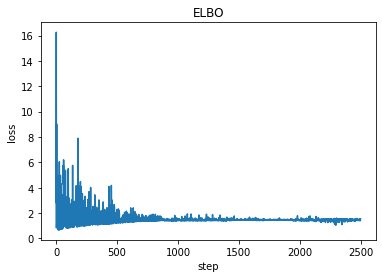

In [46]:
guess = 8.5
pyro.clear_param_store()

svi = pyro.infer.SVI(model=conditioned_scale, 
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum": 0.1}),
                     loss =pyro.infer.Trace_ELBO())

losses, a, b = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

# Stochastic Variational Inference in Pyro

In [48]:
import pyro
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist

In [49]:
def model(data):
    'APPROX PRIOR PLUS CONDITIONING'
    
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    
    for i in range(len(data)):
        
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])
        
    '''
    1. To mark conditional independence
    
    for i in pyro.plate("data_loop", len(data)):
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])
        
    2. Vectorized
    
    with pyro.plate('observe_data'):
        pyro.sample("obs", dist.Bernoulli(f), obs=data)
        
    3. Automatic subsampling for large datasets
    
    for i in pyro.plate("data_loop", len(data), subsample_size=5):
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])
        
    4. Automatic subsampling for large datasets (vectorized)
    
    with pyro.plate('observe_data', size=10, subsample_size=5) as ind:
        pyro.sample("obs", dist.Bernoulli(f), obs=data.index_select(0, ind))
    '''

In [50]:
def guide(data):
    'APPROX POSTERIOR'
    
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0), constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0), constraint=constraints.positive)
    
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

In [51]:
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = pyro.optim.Adam(adam_params)

In [52]:
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [56]:
import math
import os

smoke_test = ('CI' in os.environ)
n_steps = 2 if smoke_test else 2000

pyro.enable_validation(True)

# clear the param store in case we're in a REPL
pyro.clear_param_store()

# create some data with 6 observed heads and 4 observed tails
data = []
for _ in range(6):
    data.append(torch.tensor(1.0))
for _ in range(4):
    data.append(torch.tensor(0.0))

for step in range(n_steps):
    svi.step(data)
    if step % 100 == 0:
        print('.', end='')

....................

In [57]:
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

# here we use some facts about the beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("\nbased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))


based on the data and our prior belief, the fairness of the coin is 0.529 +- 0.090
